In [3]:
from langchain_community.utilities import SQLDatabase
from langchain_groq import ChatGroq
from langgraph.graph import StateGraph, END, START
from langchain_core.messages import AIMessage, ToolMessage, AnyMessage, HumanMessage
from langgraph.graph.message import AnyMessage, add_messages
from langchain_core.tools import tool
from typing import Annotated, Literal, TypedDict, Any
from pydantic import BaseModel, Field
from langchain_core.runnables import RunnableLambda, RunnableWithFallbacks
from langgraph.prebuilt import ToolNode
from langchain_core.prompts import ChatPromptTemplate
from langchain_community.agent_toolkits import SQLDatabaseToolkit
from dotenv import load_dotenv
import os
from IPython.display import display
import PIL
from langgraph.errors import GraphRecursionError
import os
import io
from typing import Annotated, Any, TypedDict

from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod
from typing import Optional

In [ ]:


class SQLAgent:
    def __init__(self, model="llama3-70b-8192"):
        load_dotenv()
        # Initialize instance variables
        self.db = None
        self.toolkit = None
        self.tools = None
        self.list_tables_tool = None
        self.sql_db_query = None
        self.get_schema_tool = None
        self.app = None
        
        # Setting up LLM
        self.llm = ChatGroq(model=model)
        
        # Register the tool method
        self.query_to_database = self._create_query_tool()

    def _create_query_tool(self):
        """Create the query tool bound to this instance"""
        print("creating _create_query_tool")
        @tool
        def query_to_database(query: str) -> str:
            """
            Execute a SQL query against the database and return the result.
            If the query is invalid or returns no result, an error message will be returned.
            In case of an error, the user is advised to rewrite the query and try again.
            """
            if self.db is None:
                return "Error: Database connection not established. Please set up the connection first."
            result = self.db.run_no_throw(query)
            if not result:
                return "Error: Query failed. Please rewrite your query and try again."
            return result
        
        return query_to_database

    def setup_database_connection(self, connection_string: str):
        """Set up database connection and initialize tools"""
        try:
            # Initialize database connection
            self.db = SQLDatabase.from_uri(connection_string)
            print("Database connection successful!")

            try:
                # Initialize toolkit and tools
                self.toolkit = SQLDatabaseToolkit(db=self.db, llm=self.llm)
                self.tools = self.toolkit.get_tools()
                for tool in self.tools:
                    print(f"Initialized tool: {tool.name}")

                # Create instances of the tools
                self.list_tables_tool = next((tool for tool in self.tools if tool.name == "sql_db_list_tables"), None)
                self.sql_db_query = next((tool for tool in self.tools if tool.name == "sql_db_query"), None)
                self.get_schema_tool = next((tool for tool in self.tools if tool.name == "sql_db_schema"), None)

                if not all([self.list_tables_tool, self.sql_db_query, self.get_schema_tool]):
                    raise ValueError("Failed to initialize one or more required database tools")

                # Initialize workflow and compile it into an app
                self.initialize_workflow()
                
                return self.db

            except Exception as e:
                print(f"Error initializing tools and workflow: {str(e)}")
                raise ValueError(f"Failed to initialize database tools: {str(e)}")

        except ImportError as e:
            print(f"Database driver import error: {str(e)}")
            raise ValueError(f"Missing database driver or invalid database type: {str(e)}")
        except ValueError as e:
            print(f"Invalid connection string or configuration: {str(e)}")
            raise
        except Exception as e:
            print(f"Unexpected error during database connection: {str(e)}")
            raise ValueError(f"Failed to establish database connection: {str(e)}")

    def initialize_workflow(self):
        """Initialize the workflow graph"""
        
        print("Intializing Workflow....")
        # Binding tools with LLM
        llm_to_get_schema = self.llm.bind_tools([self.get_schema_tool]) if self.get_schema_tool else None
        llm_with_tools = self.llm.bind_tools([self.query_to_database])

        class State(TypedDict):
            messages: Annotated[list[AnyMessage], add_messages]

        class SubmitFinalAnswer(BaseModel):
            final_answer: str = Field(..., description="The final answer to the user")

        llm_with_final_answer = self.llm.bind_tools([SubmitFinalAnswer])

        def handle_tool_error(state: State):
            error = state.get("error")
            tool_calls = state["messages"][-1].tool_calls
            return {"messages": [ToolMessage(content=f"Error: {repr(error)}\n please fix your mistakes.", tool_call_id=tc["id"],) for tc in tool_calls]}

        def create_node_from_tool_with_fallback(tools: list) -> RunnableWithFallbacks[Any, dict]:
            return ToolNode(tools).with_fallbacks([RunnableLambda(handle_tool_error)], exception_key="error")

        list_tables = create_node_from_tool_with_fallback([self.list_tables_tool]) if self.list_tables_tool else None
        get_schema = create_node_from_tool_with_fallback([self.get_schema_tool]) if self.get_schema_tool else None
        query_database = create_node_from_tool_with_fallback([self.query_to_database])

        query_check_system = """You are a SQL expert. Carefully review the SQL query for common mistakes, including:

                Issues with NULL handling (e.g., NOT IN with NULLs)
                Improper use of UNION instead of UNION ALL
                Incorrect use of BETWEEN for exclusive ranges
                Data type mismatches or incorrect casting
                Quoting identifiers improperly
                Incorrect number of arguments in functions
                Errors in JOIN conditions

                If you find any mistakes, rewrite the query to fix them. If it's correct, reproduce it as is."""
        query_check_prompt = ChatPromptTemplate.from_messages([("system", query_check_system), ("placeholder", "{messages}")])
        check_generated_query = query_check_prompt | llm_with_tools
        
        def check_the_given_query(state: State):
            return {"messages": [check_generated_query.invoke({"messages": [state["messages"][-1]]})]}

        query_gen_system_prompt = """You are a SQL expert with a strong attention to detail.Given an input question, output a syntactically correct SQLite query to run, then look at the results of the query and return the answer.

            1. DO NOT call any tool besides SubmitFinalAnswer to submit the final answer.

            When generating the query:

            2. Output the SQL query that answers the input question without a tool call.

            3. Unless the user specifies a specific number of examples they wish to obtain, always limit your query to at most 5 results.

            4. You can order the results by a relevant column to return the most interesting examples in the database.

            5. Never query for all the columns from a specific table, only ask for the relevant columns given the question.

            6. If you get an error while executing a query, rewrite the query and try again.

            7. If you get an empty result set, you should try to rewrite the query to get a non-empty result set.

            8. NEVER make stuff up if you don't have enough information to answer the query... just say you don't have enough information.

            9. If you have enough information to answer the input question, simply invoke the appropriate tool to submit the final answer to the user.

            10. DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the database. Do not return any sql query except answer."""
        query_gen_prompt = ChatPromptTemplate.from_messages([("system", query_gen_system_prompt), ("placeholder", "{messages}")])
        query_generator = query_gen_prompt | llm_with_final_answer

        def first_tool_call(state: State) -> dict[str, list[AIMessage]]:
            return {"messages": [AIMessage(content="", tool_calls=[{"name": "sql_db_list_tables", "args": {}, "id": "tool_abcd123"}])]}

        def generation_query(state: State):
            message = query_generator.invoke(state)
            tool_messages = []
            if message.tool_calls:
                for tc in message.tool_calls:
                    if tc["name"] != "SubmitFinalAnswer":
                        tool_messages.append(
                            ToolMessage(
                                content=f"Error: The wrong tool was called: {tc['name']}. Please fix your mistakes. Remember to only call SubmitFinalAnswer to submit the final answer. Generated queries should be outputted WITHOUT a tool call.",
                                tool_call_id=tc["id"],
                            )
                        )
            else:
                tool_messages = []
            return {"messages": [message] + tool_messages}

        def should_continue(state: State):
            messages = state["messages"]
            last_message = messages[-1]
            if getattr(last_message, "tool_calls", None):
                # Check if the tool call is SubmitFinalAnswer
                if len(last_message.tool_calls) > 0 and last_message.tool_calls[0]["name"] == "SubmitFinalAnswer":
                    return END
                else:
                    # Wrong tool called, route to error handling (not implemented here)
                    return "query_gen"  # Or a dedicated error node
            elif last_message.content.startswith("Error:"):
                return "query_gen"
            else:
                return "correct_query"

        def llm_get_schema(state: State):
            response = llm_to_get_schema.invoke(state["messages"])
            return {"messages": [response]}

        # Create workflow
        workflow = StateGraph(State)
        workflow.add_node("first_tool_call", first_tool_call)
        workflow.add_node("list_tables_tool", list_tables)
        workflow.add_node("get_schema_tool", get_schema)
        workflow.add_node("model_get_schema", llm_get_schema)
        workflow.add_node("query_gen", generation_query)
        workflow.add_node("correct_query", check_the_given_query)
        workflow.add_node("execute_query", query_database)

        workflow.add_edge(START, "first_tool_call")
        workflow.add_edge("first_tool_call", "list_tables_tool")
        workflow.add_edge("list_tables_tool", "model_get_schema")
        workflow.add_edge("model_get_schema", "get_schema_tool")
        workflow.add_edge("get_schema_tool", "query_gen")
        workflow.add_conditional_edges("query_gen", should_continue, {END: END, "correct_query": "correct_query", "query_gen": "query_gen"})
        workflow.add_edge("correct_query", "execute_query")
        workflow.add_edge("execute_query", "query_gen")

        # Compile the workflow into an executable app
        self.app = workflow.compile()
        
            
        # # Generate the graph image as bytes
        # image_bytes = self.app.get_graph().draw_mermaid_png()

        # # Convert bytes to an Image object
        # image = Image.open(io.BytesIO(image_bytes))

        # # Save the image to a file
        # image.save("workflow_graph.png")
        # print(f"Workflow graph saved")
    
    def is_query_relevant(self, query: str) -> bool:
        """Check if the query is relevant to the database using the LLM."""
        
        # Retrieve the schema of the relevant tables
        if self.list_tables_tool:
            relevant_tables = self.list_tables_tool.invoke("")
            # print(relevant_tables)
        table_list= relevant_tables.split(", ")
        print(table_list)
        # print(agent.get_schema_tool.invoke(table_list[0]))
        schema = ""
        for table in table_list:
            schema+= self.get_schema_tool.invoke(table)

        print(schema)
            
        # if self.get_schema_tool:
        #     schema_response = self.get_schema_tool.invoke({})
        #     table_schema = schema_response.content  # Assuming this returns the schema as a string

        relevance_check_prompt = (
            """You are an expert SQL agent which takes user query in Natural language and find out it have releavnce with the given schema or not. Please determine if the following query is related to a database.Here is the schema of the tables present in database:\n{schema}\n\n. If the query related to given schema respond with 'yes'. Here is the query: {query}. Answer with only 'yes' or 'no'."""
        ).format(schema=relevant_tables, query=query)
        
        response = self.llm.invoke([{"role": "user", "content": relevance_check_prompt}])
    
    # Assuming the LLM returns a simple 'yes' or 'no'
        return response.content == "yes"

    
    def execute_query(self, query: str):
        """Execute a query through the workflow"""
        if self.db is None:
            raise ValueError("Database connection not established. Please set up the connection first.")
        if self.app is None:
            raise ValueError("Workflow not initialized. Please set up the connection first.")
        # First, handle simple queries like "list tables" directly
        query_lower = query.lower()
        if any(phrase in query_lower for phrase in ["list all the tables", "show tables", "name of tables",
                                                    "which tables are present", "how many tables", "list all tables"]):
            if self.list_tables_tool:
                tables = self.list_tables_tool.invoke("")
                return f"The tables in the database are: {tables}"
            else:
                return "Error: Unable to list tables. The list_tables_tool is not initialized."

        # Check if the query is relevant to the database
        if not self.is_query_relevant(query):
            print("Not relevent to database.")
            # If not relevant, let the LLM answer the question directly
            non_relevant_prompt = (
                """You are an expert SQL agent created by Kshitij Kumrawat. You can only assist with questions related to databases so repond the user with the following example resonse and Do not answer any questions that are not related to databases.:  
                Please ask a question that pertains to database operations, such as querying tables, retrieving data, or understanding the database schema. """
            )
    
    # Invoke the LLM with the non-relevant prompt
            response = self.llm.invoke([{"role": "user", "content": non_relevant_prompt}])
            # print(response.content)
            return response.content
        
        # If relevant, proceed with the SQL workflow
        response = self.app.invoke({"messages": [HumanMessage(content=query, role="user")]})

        # More robust final answer extraction
        if (
            response
            and response["messages"]
            and response["messages"][-1].tool_calls
            and len(response["messages"][-1].tool_calls) > 0
            and "args" in response["messages"][-1].tool_calls[0]
            and "final_answer" in response["messages"][-1].tool_calls[0]["args"]
        ):
            return response["messages"][-1].tool_calls[0]["args"]["final_answer"]
        else:
            return "Error: Could not extract final answer."

In [ ]:
# create a LLM  
llm = ChatGroq(model="llama3-70b-8192")
llm



ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x000001E593993CB0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000001E593B20980>, model_name='llama3-70b-8192', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [5]:
from langchain_community.utilities import SQLDatabase
db = SQLDatabase.from_uri("sqlite:///employee.db")

In [6]:
print("Dialect:", db.dialect)
print("Usable tables:", db.get_usable_table_names())

Dialect: sqlite
Usable tables: ['customers', 'employees', 'orders']


In [7]:
from langchain_community.utilities import SQLDatabase
db = SQLDatabase.from_uri("sqlite:///employee.db")
toolkit=SQLDatabaseToolkit(db=db,llm=llm)
tools = toolkit.get_tools()
for tool in tools:
    print(tool.name)
list_tables_tool = next((tool for tool in tools if tool.name == "sql_db_list_tables"), None)
get_schema_tool = next((tool for tool in tools if tool.name == "sql_db_schema"), None)
query_checker_tool = next((tool for tool in tools if tool.name == "sql_db_query_checker"), None)
query_tool = next((tool for tool in tools if tool.name == "sql_db_query"), None)

sql_db_query
sql_db_schema
sql_db_list_tables
sql_db_query_checker


In [8]:
for tool in tools:
    print(tool.description)

Input to this tool is a detailed and correct SQL query, output is a result from the database. If the query is not correct, an error message will be returned. If an error is returned, rewrite the query, check the query, and try again. If you encounter an issue with Unknown column 'xxxx' in 'field list', use sql_db_schema to query the correct table fields.
Input to this tool is a comma-separated list of tables, output is the schema and sample rows for those tables. Be sure that the tables actually exist by calling sql_db_list_tables first! Example Input: table1, table2, table3
Input is an empty string, output is a comma-separated list of tables in the database.
Use this tool to double check if your query is correct before executing it. Always use this tool before executing a query with sql_db_query!


In [9]:
list_tables_tool = next((tool for tool in tools if tool.name == "sql_db_list_tables"), None)
get_schema_tool = next((tool for tool in tools if tool.name == "sql_db_schema"), None)
query_checker_tool = next((tool for tool in tools if tool.name == "sql_db_query_checker"), None)
query_tool = next((tool for tool in tools if tool.name == "sql_db_query"), None)


In [56]:
query_tool.invoke("SELECT * FROM Employees LIMIT 2;")

"[(1, 'Sunny', 'Savita', 'sunny.sv@abc.com', '2023-06-01', 50000.0), (2, 'Arhun', 'Meheta', 'arhun.m@gmail.com', '2022-04-15', 60000.0)]"

In [47]:
tables = list_tables_tool.invoke("")

In [49]:
tables = tables.split(",")

In [42]:
type(tables.split(","))

list

In [51]:
tables[0]

'customers'

In [ ]:
tables = tables.split(",")
schema = ""
for i in range(len(tables)):
    schema = tables[i]  +  get_schema_tool.invoke(tables[i])


In [53]:
schema

' orders\nCREATE TABLE orders (\n\torder_id INTEGER, \n\tcustomer_id INTEGER NOT NULL, \n\torder_date TEXT NOT NULL, \n\tamount REAL NOT NULL, \n\tPRIMARY KEY (order_id), \n\tFOREIGN KEY(customer_id) REFERENCES customers (customer_id)\n)\n\n/*\n3 rows from orders table:\norder_id\tcustomer_id\torder_date\tamount\n1\t1\t2023-12-01\t250.75\n2\t2\t2023-11-20\t150.5\n3\t3\t2023-11-25\t300.0\n*/'

In [10]:
llm_with_get_schema = llm.bind_tools([get_schema_tool])
llm_with_get_schema.invoke("employees").content

''

In [31]:
print(get_schema_tool.invoke(""))

TypeError: BaseTool.invoke() missing 1 required positional argument: 'input'

In [17]:
print(db_query_tool.invoke("SELECT * FROM Employees LIMIT 10;"))

[(1, 'Sunny', 'Savita', 'sunny.sv@abc.com', '2023-06-01', 50000.0), (2, 'Arhun', 'Meheta', 'arhun.m@gmail.com', '2022-04-15', 60000.0), (3, 'Alice', 'Johnson', 'alice.johnson@jpg.com', '2021-09-30', 55000.0), (4, 'Bob', 'Brown', 'bob.brown@uio.com', '2020-01-20', 45000.0)]


In [11]:
from typing import Annotated, Literal
from langchain_core.messages import AIMessage
from langchain_core.pydantic_v1 import BaseModel, Field
from typing_extensions import TypedDict
from langgraph.graph import END, StateGraph, START
from langgraph.graph.message import AnyMessage, add_messages
from typing import Any
from langchain_core.messages import ToolMessage
from langchain_core.runnables import RunnableLambda, RunnableWithFallbacks
from langgraph.prebuilt import ToolNode

In [ ]:
# LANGSMITH_TRACING="true"
# LANGSMITH_ENDPOINT="https://api.smith.langchain.com"
# LANGSMITH_API_KEY="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"
# LANGSMITH_PROJECT="pr-abandoned-inspection-61"
# OPENAI_API_KEY="<your-openai-api-key>"

In [ ]:
from dotenv import load_dotenv
load_dotenv()

os.environ["LANGSMITH_TRACING"]=os.getenv("LANGSMITH_TRACING")
os.environ["LANGSMITH_ENDPOINT"]=os.getenv("LANGSMITH_ENDPOINT")
# os.environ["LANGSMITH_API_KEY"]=os.getenv("LANGSMITH_API_KEY")
os.environ["LANGSMITH_API_KEY"]=os.getenv("LANGSMITH_API_KEY")
os.environ["LANGSMITH_PROJECT"]=os.getenv("LANGSMITH_PROJECT")
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")
llm = ChatGroq(model="llama3-70b-8192")
from langchain_community.utilities import SQLDatabase
db = SQLDatabase.from_uri("sqlite:///employee.db")
toolkit=SQLDatabaseToolkit(db=db,llm=llm)
tools = toolkit.get_tools()
# for tool in tools:
#     print(tool.name)
list_tables_tool = next((tool for tool in tools if tool.name == "sql_db_list_tables"), None)
get_schema_tool = next((tool for tool in tools if tool.name == "sql_db_schema"), None)
query_checker_tool = next((tool for tool in tools if tool.name == "sql_db_query_checker"), None)
query_tool = next((tool for tool in tools if tool.name == "sql_db_query"), None)

# create a LLM  


from langgraph.graph import StateGraph, END, MessagesState

class SQLagentState(MessagesState):
    """State for the agent"""
    next_tool : str = ""
    tables_list: str = ""
    schema_of_table: str = ""
    query_gen : str= ""
    check_query: str = ""
    execute_query : str = ""
    task_complete: bool = False
    response_to_user: str= ""
    current_task: str = ""
    query: str = ""

class DBQuery(BaseModel):
    query: str = Field(..., description="The SQL query to execute")

from langchain_core.prompts import ChatPromptTemplate
from typing import TypedDict, Annotated, List, Literal, Dict, Any

def creating_sql_agent_chain():
    """Creating a sql agent chain"""
    print("Creating a sql agent chain ")
    sql_agent_prompt  = ChatPromptTemplate.from_messages([
        ("system", """Your are a supervisor sql agent managing tools to get the answer of the user's query given in natural language using the following tools :
         1. list_table_tools - List all the tables from the connected database
         2. get_schema of tables- Get the schema of a required table. After this always call to generate_query.
         3. generate_query- Generate a query to execute and retrieve the data
         4. check_query - This tools check if the query is correct or not, if not then it corrects and provide correct query
         5. execute_query - This tools execute the query checked by the check query tool.
         6. response- This tools is used to respond with the answer generated retrived after the execution of query.
         
        Based on the current state and conversation, decide which tools should call next.
        If the task is complete, respond with 'DONE'.
         
        Current state : 
         - List of table - {tables_list}
         - schema of  required table- {schema_of_table}
         - Generated query - {query_gen}
         - Optimized query or checked query - {check_query}
         - Query execution results - {execute_query}
         - Response to user - {response_to_user}
         Respond with ONLY the tool name (list_table_tools/get_schema/generate_query/check_query/execute_query/response) or 'DONE'.


        """),
        ("human", "{task}")
        ]
    )
    print("sql agent chain has been created! ")
    return sql_agent_prompt | llm 


def sql_agent(state: SQLagentState) -> Dict: 
    """Agent decided which tools to call next to get the user query results"""
    messages = state["messages"]
    # print(messages)
    task = messages[-1].content if messages else "No task"
    print(task)
    # Store the original query in state
    if not state.get("query"):
        state["query"] = task  # Add this line to store the original query

    # check whats been completed 
    tables_list = bool(state.get("tables_list", ""))
    print(state.get("tables_list"))
    schema_of_table = bool(state.get("schema_of_table", ""))
    print(state.get("schema_of_table"))
    query_gen= bool(state.get("query_gen", ""))
    print(state.get("query_gen"))
    check_query = bool(state.get("check_query", ""))
    print(state.get("query_gen"))
    execute_query= bool(state.get("execute_query", ""))
    print(state.get("execute_query"))
    response_to_user = bool(state.get("response_to_user", ""))
    print(state.get("response_to_user"))


    chain = creating_sql_agent_chain()
    decision = chain.invoke(
        {
            "task": task,
            "tables_list": tables_list, 
            "schema_of_table":schema_of_table,
            "query_gen": query_gen,
            "check_query": check_query,
            "execute_query":execute_query,
            "response_to_user": response_to_user
        }
    )

    decision_text = decision.content.strip().lower()
    print(decision_text)

    # Respond with ONLY the tool name (list_table_tools/get_schema/generate_query/check_query/execute_query/response) or 'DONE'.


    if "done" in decision_text :
        next_tool = "end"
        agent_msg = "✅ SQL Agent: All tasks complete!"
    elif "list_table_tools" in decision_text:
        next_tool = "get_schema"
        agent_msg = "📋 SQL Agent: lets list all the tables in database."
    elif "get_schema" in decision_text :
        next_tool = "generate_query"
        agent_msg = "📋 SQL Agent: Lets get the schema of the table from database "
    elif "generate_query" in decision_text :
        next_tool = "check_query"
        agent_msg = "📋 SQL Agent: Lets generate the  SQL query to retrive information "
    elif "check_query" in decision_text :
        next_tool = "execute_query"
        agent_msg = "📋 SQL Agent:Lets check the SQL query if it is correct or not. "
    elif "execute_query" in decision_text:
        next_tool = "response"
        agent_msg = "📋 SQL Agent: Lets execute the query and retrive results"
    elif "response" in decision_text :
        next_tool = "end"
        agent_msg = "📋 SQL Agent: Creating a response according to retrival from SQL query executed!"
    else:
        next_tool = "end"
        agent_msg = "✅ SQL Agent: Task seems complete."
    
    return {
        "messages": [AIMessage(content=agent_msg)],
        "next_tool": next_tool,
        "current_task": task
    }


def list_table_tools(state: SQLagentState)-> Dict:
    """List all the tables"""
    tables_list =  list_tables_tool.invoke("")
    print(f"table list {tables_list}")
    return {
        "messages": [AIMessage(content=tables_list)],
        "tables_list": tables_list,
        # "next_tool": "get_schema"
        "next_tool": "sql_agent"
    }

# def get_schema(state: SQLagentState)-> Dict:
#     """Get the schema of the required table"""
#     # bind the tool with llm 
#     # llm_to_get_schema = llm.bind_tools([get_schema_tool]) if get_schema_tool else None
#     tables_list =  list_tables_tool.invoke("")
#     print(f"table list {tables_list}")
#     print("Entered in the get schema function")
#     # tables_list = state.get("tables_list","")
#     print(f"Tables list are to get schema of : {tables_list}")
#     tables = tables_list.split(",")
#     schema = ""
#     for i in range(len(tables)):
#         schema = tables[i]  +  get_schema_tool.invoke(tables[i])
#     print(f"Schema of the database: {schema}")

#     return {
#         "messages": [AIMessage(content=schema)],
#         "schema_of_table": schema,
#         # "next_tool": "generate_query"
#         "next_tool": "sql_agent" 
#         }

def get_schema(state: SQLagentState) -> Dict:
    print("📘 Entering get_schema function...")
    tables_list = list_tables_tool.invoke("")
    print(f"✅ Tables found: {tables_list}")

    tables = tables_list.split(", ")
    full_schema = ""
    for table in tables:
        schema = get_schema_tool.invoke(table)
        full_schema += f"\n{table}\n{schema}"

    print(f"📘 Full schema collected: {full_schema}")
    return {
        "messages": [AIMessage(content=full_schema)],
        "schema_of_table": full_schema,
        "tables_list": tables_list,
        "next_tool": "sql_agent"
    }

# def generate_query(state: SQLagentState) -> Dict:
#     """Generate a SQL Query according to the user query with the help of schema"""

#     schema = state.get("schema_of_table","")
#     print(f"Messages in generate query: {schema}")
#     generate_query_system_prompt = """ 
#          You are a SQL expert that generates precise SQL queries based on user questions.
            
#             You will be provided with state messages in placeholder which contains:
#             1. The user's question
#             2. All the tables in the database
#             3. The complete schema information for those tables
            
#             IMPORTANT STEPS:
#             1. Analyze the provided schema information carefully
#             2. Pay special attention to:
#             - Primary and foreign keys for joins
#             - Column names and data types
#             - Relationships between tables
#             3. Generate a SQL query that:
#             - Uses the correct column names as shown in the schema
#             - Properly joins tables using the correct keys
#             - Includes appropriate WHERE clauses for filtering
#             - If the user's question is about a specific time period, include a date filter in the query
#             - If the user's question is about a specific value, include a filter for that value in the query
#             - Uses proper aggregation functions when needed
            
#             Remember to:
#             - Always verify column names exist in the schema before using them
#             - Use appropriate JOIN conditions based on the foreign key relationships
#             - Include proper date formatting for date-related queries
#             - Consider NULL handling where appropriate
            
#             Return only the SQL query, nothing else.
        
#         """
#     generate_query_prompt = ChatPromptTemplate.from_messages([
#             ("system", generate_query_system_prompt),
#             ("placeholder", "{schema}")
#         ])
#     formatted_generate_query_prompt = generate_query_prompt.invoke({"messages":schema})  # Format the prompt

#     generate_query_llm = llm.with_structured_output(DBQuery)
#     generate_query_result = generate_query_llm.invoke(formatted_generate_query_prompt)
#     print("--------------------------------")
#     print(generate_query_result.query)
#     print("--------------------------------Query generated--------------------------------")
#     # return {"messages": state["messages"] + [AIMessage(content = f"{generate_query_result.query}")]}

#     return {
#         "messages": [AIMessage(content=generate_query_result.query)],
#         "query_gen": generate_query_result.query,
#         "next_tool": "check_query"
#     }

def generate_query(state: SQLagentState) -> Dict:
    """Generate a SQL Query according to the user query with the help of schema"""

    schema = state.get("schema_of_table", "")
    human_query = state.get("query", "")  # ✅ This stores the user input
    tables = state.get("tables_list", "")

    print(f"Human query: {human_query}")
    print(f"Tables: {tables}")
    print(f"Schema: {schema}")

    generate_query_system_prompt = """ 
        You are a SQL expert that generates precise SQL queries based on user questions.
        
        You will be provided with the following context:
        1. The user's question
        2. All the tables in the database
        3. The complete schema information for those tables

        Analyze the schema and generate a SQL query that:
        - Uses correct column names from schema
        - Properly joins tables
        - Uses WHERE clauses and filters based on user query
        - Includes aggregation, date filtering, etc. if needed

        Respond ONLY with the SQL query. Do not explain.
    """

    combined_input = f"""
    User Question: {human_query}
    Tables: {tables}
    Schema: {schema}
    """

    generate_query_prompt = ChatPromptTemplate.from_messages([
        ("system", generate_query_system_prompt),
        ("human", "{input}")
    ])
    print(f"Query generation prompt : {generate_query_prompt}")

    formatted_prompt = generate_query_prompt.invoke({"input": combined_input})

    generate_query_llm = llm.with_structured_output(DBQuery)
    print(f"generate_query_llm : {generate_query_llm}")

    
    generate_query_result = generate_query_llm.invoke(formatted_prompt)
    print("--------------------------------")
    print(generate_query_result.query)
    print("--------------------------------Query generated--------------------------------")

    return {
            "messages": [AIMessage(content=generate_query_result.query)],
            "query_gen": generate_query_result.query,
            # "next_tool": "check_query"
            "next_tool": "sql_agent"
        }

    # except Exception as e:
    #     print(f"Query generation failed: {e}")
    #     return {
    #         "messages": [AIMessage(content="⚠️ Failed to generate SQL query.")],
    #         "query_gen": "",
    #         # "next_tool": "sql_agent"
    #         "next_tool": "sql_agent"
    #     }

# # ✅ Pass query string into initial state
# def run_query_with_user_input(user_query: str):
#     return graph.invoke(SQLagentState(messages=[HumanMessage(content=user_query)], query=user_query))

# # ✅ Debug check: Make sure 'query' exists in state for generate_query
# def generate_query(state: SQLagentState) -> Dict:
#     schema = state.get("schema_of_table", "")
#     human_query = state.get("query", "")
#     tables = state.get("tables_list", "")

#     print(f"👤 Human query: {human_query}")
#     print(f"📘 Tables: {tables}")
#     print(f"📘 Schema: {schema}")

#     generate_query_system_prompt = """You are a SQL expert that generates precise SQL queries based on user questions.
# You will be provided with the following:
# - User's question
# - List of tables
# - Complete schema

# Respond ONLY with the SQL query. Do not explain."""

#     combined_input = f"""
# User Question: {human_query}
# Tables: {tables}
# Schema: {schema}
#     """

#     from langchain_core.prompts import ChatPromptTemplate
#     generate_query_prompt = ChatPromptTemplate.from_messages([
#         ("system", generate_query_system_prompt),
#         ("human", "{input}")
#     ])

#     formatted_prompt = generate_query_prompt.invoke({"input": combined_input})
#     generate_query_llm = llm.with_structured_output(DBQuery)

#     try:
#         result = generate_query_llm.invoke(formatted_prompt)
#         print(f"✅ Query generated: {result.query}")
#         return {
#             "messages": [AIMessage(content=result.query)],
#             "query_gen": result.query,
#             "next_tool": "sql_agent"
#         }
#     except Exception as e:
#         print(f"❌ Failed to generate query: {e}")
#         return {
#             "messages": [AIMessage(content="⚠️ Failed to generate SQL query.")],
#             "query_gen": "",
#             "next_tool": "sql_agent"
#         }




def check_query(state: SQLagentState) -> Dict: 
    """Check the query if it is correct or not. if not correct it"""
    query = state.get("query_gen","")
    optimized_query = query_checker_tool.invoke(query)
    return {
        "messages": [AIMessage(content=optimized_query)],
        "check_query": optimized_query,
        # "next_tool": "execute_query"
        "next_tool": "sql_agent"
    }

def execute_query(state: SQLagentState)-> Dict:
    """Execute the SQL query"""
    query = state.get("check_query","")
    print(f"Query to be executed: {query}")    

    results = query_tool.invoke(query)
    print( f"RESULT: {results}")

    return {
        "messages": [AIMessage(content=results)],
        "execute_query": results,
        # "next_tool": "response_to_user"
        "next_tool": "sql_agent"
    }

# def create_response(state: SQLagentState) -> Dict: 
#     """Create a final Answer regarding user query"""
#     query= state.get("check_query","")
#     result = state.get("execute_query","")
#     human_query = state.get("query","")
#     print(f"Result of the excuted query {result}")
#     response_prompt  = f"""You have to create a response for the following executed query and its result in the proper way. It should not be too much big. Also given the human natural query.
#          - human natural language query -{human_query}
#          - SQL query - {query}
#          - Query execution results - {result}
#          """
#     response = llm.invoke([HumanMessage(content = response_prompt)])
#     print(f"response:{response.content}")
#     print(f"response ended")

#     return {
#         "messages": [AIMessage(content=response)],
#         "response_to_user": response,
#         "next_tool": "__end__",
#         "task_complete": True
#     }

def create_response(state: SQLagentState) -> Dict: 
    """Create a final Answer regarding user query"""
    print("Entered in create response !!!!")
    query = state.get("check_query", "")
    print(f"Query : {query}")
    result = state.get("execute_query", "")
    print(f"result : {result}")
    human_query = state.get("query", "")
    print(f"Human query : {human_query}")
    print(f"Result of the executed query {result}")
    
    response_prompt = f"""You have to create a response for the following executed query and its result in a proper way.
    It should be short and relevant. Also include the human natural query.
    
    - Human Query: {human_query}
    - SQL Query: {query}
    - Query Result: {result}
    """
    
    response = llm.invoke([HumanMessage(content=response_prompt)])
    print(f"Printing response in format: {response}")  # already returns AIMessage
    
    return {
        "messages": [response],  # ✅ no need to wrap again
        "response_to_user": response.content,
        # "next_tool": "__end__",
        "next_tool": "sql_agent",
        "task_complete": True
    }


# (list_table_tools/get_schema/generate_query/check_query/execute_query/response


def router(state: SQLagentState):
    print("🔁 Entering router...")
    next_tool = state.get("next_tool", "")
    print(f"➡️ Next tool: {next_tool}")

    if next_tool == "end" or state.get("task_complete", False):
        return END
    return next_tool if next_tool in [
        "sql_agent", "list_table_tools", "get_schema", "generate_query",
        "check_query", "execute_query", "create_response"
    ] else "sql_agent"




# creating workflow 
workflow = StateGraph(SQLagentState)

workflow.add_node("sql_agent", sql_agent)
workflow.add_node("list_table_tools", list_table_tools)
workflow.add_node("get_schema", get_schema)
workflow.add_node("generate_query", generate_query)
workflow.add_node("check_query", check_query)
workflow.add_node("execute_query", execute_query)
workflow.add_node("response", create_response)


workflow.set_entry_point("sql_agent")

# Add routing
for node in ["sql_agent","list_table_tools", "get_schema", "generate_query", "check_query","execute_query","response"]:
    workflow.add_conditional_edges(
        node,
        router,
        {
            "sql_agent": "sql_agent",
            "list_table_tools": "list_table_tools",
            "get_schema": "get_schema",
            "generate_query": "generate_query",
            "check_query": "check_query",
            "execute_query": "execute_query",
            "response": "response",
            END: END
        }
    )

graph=workflow.compile()


In [ ]:
result = run_query_with_user_input("Give me the 2 employees from employees table")
print(result)


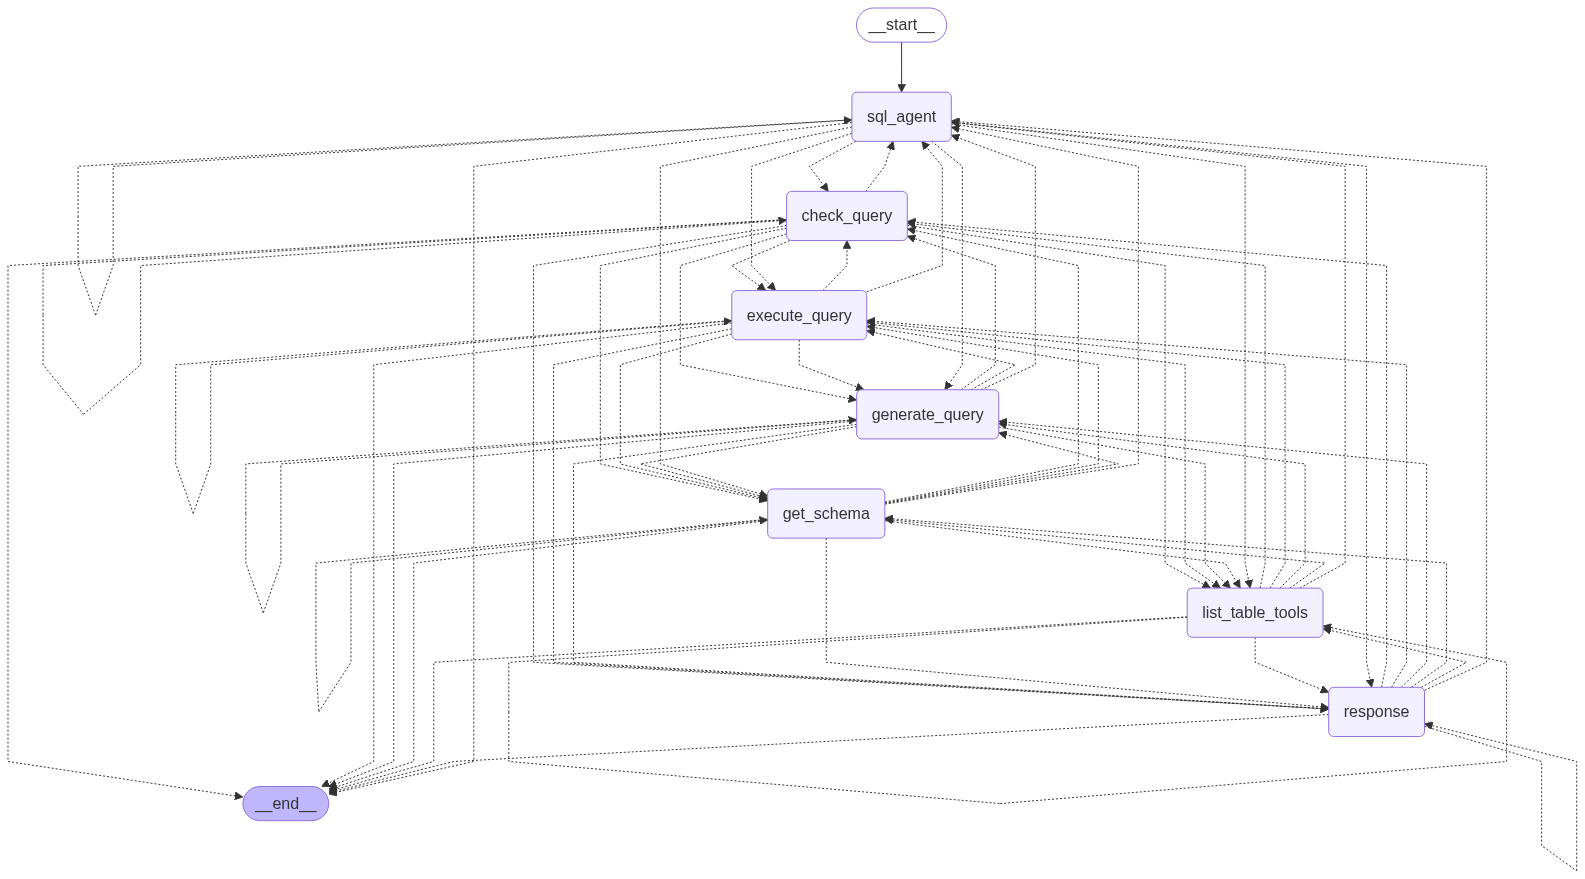

In [ ]:
from dotenv import load_dotenv
import os
load_dotenv()

os.environ["LANGSMITH_TRACING"]=os.getenv("LANGSMITH_TRACING")
os.environ["LANGSMITH_ENDPOINT"]=os.getenv("LANGSMITH_ENDPOINT")
os.environ["LANGSMITH_API_KEY"]=os.getenv("LANGSMITH_API_KEY")
os.environ["LANGSMITH_PROJECT"]=os.getenv("LANGSMITH_PROJECT")
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")

from langchain_community.utilities import SQLDatabase
from langchain_community.agent_toolkits import SQLDatabaseToolkit
from langchain_groq import ChatGroq
from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langgraph.graph import StateGraph, END, MessagesState
from typing import TypedDict, Annotated, List, Literal, Dict, Any

# Initialize LLM first
llm = ChatGroq(model="llama3-70b-8192")
# Initialize database and tools
db = SQLDatabase.from_uri("sqlite:///employee.db")
toolkit = SQLDatabaseToolkit(db=db, llm=llm)
tools = toolkit.get_tools()

# Get specific tools
list_tables_tool = next((tool for tool in tools if tool.name == "sql_db_list_tables"), None)
get_schema_tool = next((tool for tool in tools if tool.name == "sql_db_schema"), None)
query_checker_tool = next((tool for tool in tools if tool.name == "sql_db_query_checker"), None)
query_tool = next((tool for tool in tools if tool.name == "sql_db_query"), None)

class SQLagentState(MessagesState):
    """State for the agent"""
    next_tool: str = ""
    tables_list: str = ""
    schema_of_table: str = ""
    query_gen: str = ""
    check_query: str = ""
    execute_query: str = ""
    task_complete: bool = False
    response_to_user: str = ""
    current_task: str = ""
    query: str = ""

class DBQuery(BaseModel):
    query: str = Field(..., description="The SQL query to execute")

def creating_sql_agent_chain():
    """Creating a sql agent chain"""
    print("Creating a sql agent chain")
    sql_agent_prompt = ChatPromptTemplate.from_messages([
        ("system", """You are a supervisor SQL agent managing tools to get the answer to the user's query.
        
        Based on the current state, decide which tool should be called next:
        1. list_table_tools - List all tables from the database
        2. get_schema - Get the schema of required tables
        3. generate_query - Generate a SQL query
        4. check_query - Check if the query is correct
        5. execute_query - Execute the query
        6. response - Create response for the user
        
        Current state:
        - Tables listed: {tables_list}
        - Schema retrieved: {schema_of_table}
        - Query generated: {query_gen}
        - Query checked: {check_query}
        - Query executed: {execute_query}
        - Response created: {response_to_user}
        
        If no tables are listed, respond with 'list_table_tools'.
        If tables are listed but no schema, respond with 'get_schema'.
        If schema exists but no query generated, respond with 'generate_query'.
        If query generated but not checked, respond with 'check_query'.
        If query checked but not executed, respond with 'execute_query'.
        If query executed but no response, respond with 'response'.
        If everything is complete, respond with 'DONE'.
        
        Respond with ONLY the tool name or 'DONE'.
        """),
        ("human", "{task}")
    ])
    return sql_agent_prompt | llm

def sql_agent(state: SQLagentState) -> Dict:
    """Agent decides which tool to call next"""
    messages = state["messages"]
    task = messages[-1].content if messages else "No task"
    
    # Store the original query in state if not already stored
    if not state.get("query"):
        state["query"] = task
    
    # Check what's been completed (convert to boolean properly)
    tables_list = bool(state.get("tables_list", "").strip())
    schema_of_table = bool(state.get("schema_of_table", "").strip())
    query_gen = bool(state.get("query_gen", "").strip())
    check_query = bool(state.get("check_query", "").strip())
    execute_query = bool(state.get("execute_query", "").strip())
    response_to_user = bool(state.get("response_to_user", "").strip())
    
    print(f"State check - Tables: {tables_list}, Schema: {schema_of_table}, Query: {query_gen}, Check: {check_query}, Execute: {execute_query}, Response: {response_to_user}")
    
    chain = creating_sql_agent_chain()
    decision = chain.invoke({
        "task": task,
        "tables_list": tables_list,
        "schema_of_table": schema_of_table,
        "query_gen": query_gen,
        "check_query": check_query,
        "execute_query": execute_query,
        "response_to_user": response_to_user
    })
    
    decision_text = decision.content.strip().lower()
    print(f"Agent decision: {decision_text}")
    
    if "done" in decision_text:
        next_tool = "end"
        agent_msg = "✅ SQL Agent: All tasks complete!"
    elif "list_table_tools" in decision_text:
        next_tool = "list_table_tools"
        agent_msg = "📋 SQL Agent: Listing all tables in database."
    elif "get_schema" in decision_text:
        next_tool = "get_schema"
        agent_msg = "📋 SQL Agent: Getting schema of tables."
    elif "generate_query" in decision_text:
        next_tool = "generate_query"
        agent_msg = "📋 SQL Agent: Generating SQL query."
    elif "check_query" in decision_text:
        next_tool = "check_query"
        agent_msg = "📋 SQL Agent: Checking SQL query."
    elif "execute_query" in decision_text:
        next_tool = "execute_query"
        agent_msg = "📋 SQL Agent: Executing query."
    elif "response" in decision_text:
        next_tool = "response"
        agent_msg = "📋 SQL Agent: Creating response."
    else:
        next_tool = "end"
        agent_msg = "✅ SQL Agent: Task complete."
    
    return {
        "messages": [AIMessage(content=agent_msg)],
        "next_tool": next_tool,
        "current_task": task
    }

def list_table_tools(state: SQLagentState) -> Dict:
    """List all the tables"""
    tables_list = list_tables_tool.invoke("")
    print(f"Tables found: {tables_list}")
    return {
        "messages": [AIMessage(content=f"Tables found: {tables_list}")],
        "tables_list": tables_list,
        "next_tool": "sql_agent"
    }

def get_schema(state: SQLagentState) -> Dict:
    """Get the schema of required tables"""
    print("📘 Getting schema...")
    tables_list = state.get("tables_list", "")
    if not tables_list:
        tables_list = list_tables_tool.invoke("")
    
    tables = [table.strip() for table in tables_list.split(",")]
    full_schema = ""
    
    for table in tables:
        try:
            schema = get_schema_tool.invoke(table)
            full_schema += f"\nTable: {table}\n{schema}\n"
        except Exception as e:
            print(f"Error getting schema for {table}: {e}")
    
    print(f"📘 Schema collected for tables: {tables}")
    return {
        "messages": [AIMessage(content=f"Schema retrieved: {full_schema}")],
        "schema_of_table": full_schema,
        "tables_list": tables_list,
        "next_tool": "sql_agent"
    }

def generate_query(state: SQLagentState) -> Dict:
    """Generate a SQL Query according to the user query"""
    schema = state.get("schema_of_table", "")
    human_query = state.get("query", "")
    tables = state.get("tables_list", "")
    
    print(f"Generating query for: {human_query}")
    
    generate_query_system_prompt = """You are a SQL expert that generates precise SQL queries based on user questions.
    
    You will be provided with:
    - User's question
    - Available tables
    - Complete schema information
    
    Generate a SQL query that:
    - Uses correct column names from schema
    - Properly joins tables if needed
    - Includes appropriate WHERE clauses
    - Uses proper aggregation functions when needed
    
    Respond ONLY with the SQL query. Do not explain."""
    
    combined_input = f"""
    User Question: {human_query}
    Tables: {tables}
    Schema: {schema}
    """
    
    generate_query_prompt = ChatPromptTemplate.from_messages([
        ("system", generate_query_system_prompt),
        ("human", "{input}")
    ])
    
    try:
        formatted_prompt = generate_query_prompt.invoke({"input": combined_input})
        generate_query_llm = llm.with_structured_output(DBQuery)
        result = generate_query_llm.invoke(formatted_prompt)
        
        print(f"✅ Query generated: {result.query}")
        return {
            "messages": [AIMessage(content=f"Query generated: {result.query}")],
            "query_gen": result.query,
            "next_tool": "sql_agent"
        }
    except Exception as e:
        print(f"❌ Failed to generate query: {e}")
        return {
            "messages": [AIMessage(content="⚠️ Failed to generate SQL query.")],
            "query_gen": "",
            "next_tool": "sql_agent"
        }

def check_query(state: SQLagentState) -> Dict:
    """Check if the query is correct"""
    query = state.get("query_gen", "")
    print(f"Checking query: {query}")
    
    if not query:
        return {
            "messages": [AIMessage(content="No query to check")],
            "check_query": "",
            "next_tool": "sql_agent"
        }
    
    try:
        checked_query = query_checker_tool.invoke(query)
        print(f"Query checked: {checked_query}")
        return {
            "messages": [AIMessage(content=f"Query checked: {checked_query}")],
            "check_query": checked_query if checked_query else query,
            "next_tool": "sql_agent"
        }
    except Exception as e:
        print(f"Error checking query: {e}")
        return {
            "messages": [AIMessage(content="Query check failed, using original query")],
            "check_query": query,
            "next_tool": "sql_agent"
        }

def execute_query(state: SQLagentState) -> Dict:
    """Execute the SQL query"""
    query = state.get("check_query", "") or state.get("query_gen", "")
    print(f"Executing query: {query}")
    
    if not query:
        return {
            "messages": [AIMessage(content="No query to execute")],
            "execute_query": "",
            "next_tool": "sql_agent"
        }
    
    try:
        results = query_tool.invoke(query)
        print(f"Query results: {results}")
        return {
            "messages": [AIMessage(content=f"Query executed successfully: {results}")],
            "execute_query": results,
            "next_tool": "sql_agent"
        }
    except Exception as e:
        print(f"Error executing query: {e}")
        return {
            "messages": [AIMessage(content=f"Query execution failed: {e}")],
            "execute_query": "",
            "next_tool": "sql_agent"
        }

def create_response(state: SQLagentState) -> Dict:
    """Create a final response for the user"""
    print("Creating final response...")
    
    query = state.get("check_query", "") or state.get("query_gen", "")
    result = state.get("execute_query", "")
    human_query = state.get("query", "")
    
    response_prompt = f"""Create a clear, concise response for the user based on:
    
    User Question: {human_query}
    SQL Query: {query}
    Query Result: {result}
    
    Provide a natural language answer that directly addresses the user's question."""
    
    try:
        response = llm.invoke([HumanMessage(content=response_prompt)])
        print(f"Response created: {response.content}")
        
        return {
            "messages": [response],
            "response_to_user": response.content,
            "next_tool": "sql_agent",
            "task_complete": True
        }
    except Exception as e:
        print(f"Error creating response: {e}")
        return {
            "messages": [AIMessage(content="Failed to create response")],
            "response_to_user": "",
            "next_tool": "sql_agent",
            "task_complete": True
        }

def router(state: SQLagentState):
    """Route to the next node"""
    print("🔁 Entering router...")
    next_tool = state.get("next_tool", "")
    print(f"➡️ Next tool: {next_tool}")
    
    if next_tool == "end" or state.get("task_complete", False):
        return END
    
    valid_tools = [
        "sql_agent", "list_table_tools", "get_schema", "generate_query",
        "check_query", "execute_query", "response"
    ]
    
    return next_tool if next_tool in valid_tools else "sql_agent"

# Create workflow
workflow = StateGraph(SQLagentState)

# Add nodes
workflow.add_node("sql_agent", sql_agent)
workflow.add_node("list_table_tools", list_table_tools)
workflow.add_node("get_schema", get_schema)
workflow.add_node("generate_query", generate_query)
workflow.add_node("check_query", check_query)
workflow.add_node("execute_query", execute_query)
workflow.add_node("response", create_response)

# Set entry point
workflow.set_entry_point("sql_agent")

# Add routing
for node in ["sql_agent", "list_table_tools", "get_schema", "generate_query", "check_query", "execute_query", "response"]:
    workflow.add_conditional_edges(
        node,
        router,
        {
            "sql_agent": "sql_agent",
            "list_table_tools": "list_table_tools",
            "get_schema": "get_schema",
            "generate_query": "generate_query",
            "check_query": "check_query",
            "execute_query": "execute_query",
            "response": "response",
            END: END
        }
    )

# Compile the graph
graph = workflow.compile()
graph
# Test the workflow
# if __name__ == "__main__":
    # Correct way to invoke the graph
   

In [115]:
response = graph.invoke({
        "messages": [HumanMessage(content="")],
        "query": "Give me all orders less than 200"
    })
print("Final response:", response)

State check - Tables: False, Schema: False, Query: False, Check: False, Execute: False, Response: False
Creating a sql agent chain
Agent decision: list_table_tools
🔁 Entering router...
➡️ Next tool: list_table_tools
Tables found: customers, employees, orders
🔁 Entering router...
➡️ Next tool: sql_agent
State check - Tables: True, Schema: False, Query: False, Check: False, Execute: False, Response: False
Creating a sql agent chain
Agent decision: get_schema
🔁 Entering router...
➡️ Next tool: get_schema
📘 Getting schema...
📘 Schema collected for tables: ['customers', 'employees', 'orders']
🔁 Entering router...
➡️ Next tool: sql_agent
State check - Tables: True, Schema: True, Query: False, Check: False, Execute: False, Response: False
Creating a sql agent chain
Agent decision: generate_query
🔁 Entering router...
➡️ Next tool: generate_query
Generating query for: Give me all orders less than 200
✅ Query generated: SELECT * FROM orders WHERE amount < 200
🔁 Entering router...
➡️ Next tool: s

In [110]:
response["messages"][-1].content

'Here are the 2 employees from the employees table: \n\nEmployee 1: Sunny Savita with email sunny.sv@abc.com\nEmployee 2: Arhun Meheta with email arhun.m@gmail.com'

In [105]:
response = graph.invoke({"messages": [HumanMessage(content="Give me the 2 employees from employees table")]})
print(response[])

Give me the 2 employees from employees table
None
None
None
None
None
None
Creating a sql agent chain 
sql agent chain has been created! 
list_table_tools
🔁 Entering router...
➡️ Next tool: get_schema
📘 Entering get_schema function...
✅ Tables found: customers, employees, orders
📘 Full schema collected: 
customers

CREATE TABLE customers (
	customer_id INTEGER, 
	first_name TEXT NOT NULL, 
	last_name TEXT NOT NULL, 
	email TEXT NOT NULL, 
	phone TEXT, 
	PRIMARY KEY (customer_id), 
	UNIQUE (email)
)

/*
3 rows from customers table:
customer_id	first_name	last_name	email	phone
1	John	Doe	john.doe@example.com	1234567890
2	Jane	Smith	jane.smith@example.com	9876543210
3	Emily	Davis	emily.davis@example.com	4567891230
*/
employees

CREATE TABLE employees (
	emp_id INTEGER, 
	first_name TEXT NOT NULL, 
	last_name TEXT NOT NULL, 
	email TEXT NOT NULL, 
	hire_date TEXT NOT NULL, 
	salary REAL NOT NULL, 
	PRIMARY KEY (emp_id), 
	UNIQUE (email)
)

/*
3 rows from employees table:
emp_id	first_name	

GraphRecursionError: Recursion limit of 25 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/GRAPH_RECURSION_LIMIT

In [69]:
# print(response['messages'][-1].content)
print(response['messages'][-1].content)

However, I don't see the query and its result. Please provide the following information so I can create a proper response:

1. **Human Query**: The question or problem that a user is trying to solve.
2. **SQL Query**: The SQL statement that is executed to retrieve the data.
3. **Query Result**: The actual output or data returned by the SQL query.

Once I have this information, I'll create a concise and relevant response.


In [63]:
response=graph.invoke(HumanMessage(content="Give me the 2 employees from employees table"))

[]


KeyError: "Input to ChatPromptTemplate is missing variables {'check_query'}.  Expected: ['check_query', 'execute_query', 'query_gen', 'response_to_user', 'schema_of_table', 'tables_list', 'task'] Received: ['task', 'tables_list', 'schema_of_table', 'query_gen', 'check_query ', 'execute_query', 'response_to_user']\nNote: if you intended {check_query} to be part of the string and not a variable, please escape it with double curly braces like: '{{check_query}}'.\nFor troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/INVALID_PROMPT_INPUT "

In [19]:
class SubmitFinalAnswer(BaseModel):
    """Submit the final answer to the user based on the query results."""
    final_answer: str = Field(..., description="The final answer to the user")

In [ ]:
class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

In [ ]:
# Add a node for a model to generate a query based on the question and schema
query_gen_system = """You are a SQL expert with a strong attention to detail.

Given an input question, output a syntactically correct SQLite query to run, then look at the results of the query and return the answer.

DO NOT call any tool besides SubmitFinalAnswer to submit the final answer.

When generating the query:

Output the SQL query that answers the input question without a tool call.

Unless the user specifies a specific number of examples they wish to obtain, always limit your query to at most 5 results.
You can order the results by a relevant column to return the most interesting examples in the database.
Never query for all the columns from a specific table, only ask for the relevant columns given the question.

If you get an error while executing a query, rewrite the query and try again.

If you get an empty result set, you should try to rewrite the query to get a non-empty result set.
NEVER make stuff up if you don't have enough information to answer the query... just say you don't have enough information.

If you have enough information to answer the input question, simply invoke the appropriate tool to submit the final answer to the user.

DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the database. Do not return any sql query except answer."""


query_gen_prompt = ChatPromptTemplate.from_messages([("system", query_gen_system), ("placeholder", "{messages}")])

query_gen = query_gen_prompt | llm.bind_tools([SubmitFinalAnswer])

In [24]:
query_checker_tool.invoke( "SELECT + FROM Employes LMIT 5;")

'SELECT * FROM Employees LIMIT 5;'